In [24]:
import requests

def make_request(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

### Her må det legges inn data

In [79]:
# Get price data for month
price_from_fortum_per_kwh = 0.5259
year = 2023
period = 10 
# Make a list of the days in the month. Make sure to have the right number of days (Days + 1).
days = [str(day).zfill(2) for day in range(1, 32)]


In [64]:
# Get price data for month

month_prices = {}
for day in days:
    url = f"https://www.hvakosterstrommen.no/api/v1/prices/{str(year)}/{str(period).zfill(2)}-{day}_NO1.json"
    data = make_request(url)
    if data:
        month_prices[day] = data

print(len(month_prices))


31


### Denne må endres til riktig fil

In [67]:
import json
# Get the file for the month
with open(f'strømforbruk-2023-10.json', 'r') as file:
    strom_data = json.load(file)

# Now `strom_data` is a Python dictionary that contains the parsed JSON data

In [68]:
from typing import List

timer: List[dict] = strom_data["Years"][0]["Months"][0]["Days"][0]["Hours"]
dager: List[dict] = strom_data["Years"][0]["Months"][0]["Days"]
print(len(timer))
print(len(dager))
print(timer[0]["Consumption"]["Value"])

24
31
2.23


In [69]:
# Check if all days have 24 hours
arr = []
len(month_prices["25"])
for i, day in enumerate(month_prices):
    if len(month_prices[day]) != 24:
        print(f"Day {day} has {len(month_prices[day])} hours")
    arr.append(len(month_prices[day]))
print(arr)

Day 29 has 25 hours
[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 24, 24]


In [70]:
# Totalt antall kilowattimer i month
total_days = 0
total_hours = 0
total = 0

for day in dager:
    total_days += 1
    # add a new key to the dictionary
    for hour in day["Hours"]:
        total_hours += 1
        total += hour["Consumption"]["Value"]

print(total_days)
print(total_hours)
print(f'Totalt antall kwh: {total:.2f}')


31
744
Totalt antall kwh: 1545.85


In [71]:
# Set an object with all the prices for the month
price_object = {}
for day in month_prices:
  hour_prices = {}
  for i, hour in enumerate(month_prices[day]):
    hour_prices[i] = hour["NOK_per_kWh"]
  price_object[day] = hour_prices

print(len(price_object))
print(price_object["01"])



31
{0: -0.02239, 1: -0.02273, 2: -0.02341, 3: -0.02352, 4: -0.02329, 5: -0.02329, 6: -0.02251, 7: -0.02014, 8: -0.01204, 9: -0.00529, 10: -0.00135, 11: -0.00079, 12: -0.00248, 13: -0.02127, 14: -0.00822, 15: -0.0018, 16: 0.00011, 17: 0.00574, 18: 0.01069, 19: 0.01621, 20: 0.01553, 21: 0.00912, 22: -0.00158, 23: -0.00878}


In [72]:
# Set the spotPrice to each hour in the month
for day in dager:
    day_num = str(day["Day"]).zfill(2)
    for i, hour in enumerate(day["Hours"]):
        hour["SpotPrice"] = price_object[day_num][i]

# print(json.dumps(dager[0]["Hours"][0], indent=4))

In [73]:
# Build an array  of days with kwh and cost
day_data = []
for i, day in enumerate(dager):
    kwh = 0
    cost = 0
    for hour in day["Hours"]:
        kwh += hour["Consumption"]["Value"]
        cost += hour["Consumption"]["Value"] * hour["SpotPrice"]
    day_data.append({"Day": day["Day"], "KWH": kwh, "Cost": cost})
print(day_data[:1])
    

[{'Day': 1, 'KWH': 15.57, 'Cost': -0.17489680000000005}]


In [74]:
# My actual consumption

# Calculate total cost and total kwh for the month
total_kwh = 0
total_cost = 0
num_days = 0
for day in day_data:
    num_days += 1
    total_kwh += day["KWH"]
    total_cost += day["Cost"]

# Calculate average cost per kwh
average_cost = total_cost / total_kwh

# Calculate average price per kwh
average_price = total_cost / num_days

total_cost_incl_mva = total_cost * 1.25
average_cost_incl_mva = average_cost * 1.25

print(f"Totalt antall dager: {num_days}")
print(f"Totalt antall kwh: {total_kwh:.2f}")
print(f"Totalt antall kroner: {total_cost:.2f}")
print(f"Totalt antall kroner inkl mva: {total_cost_incl_mva:.2f}")
print(f"Gjennomsnittlig pris per kwh forbrukt i øre: {average_cost*100:.2f}")
print(f"Gjennomsnittlig pris per kwh ink mva i øre: {average_cost*1.25*100:.2f}")
print(f"Gjennomsnittlig pris for måneden per dag: {average_price:.2f}")



Totalt antall dager: 31
Totalt antall kwh: 1545.85
Totalt antall kroner: 713.19
Totalt antall kroner inkl mva: 891.49
Gjennomsnittlig pris per kwh forbrukt i øre: 46.14
Gjennomsnittlig pris per kwh ink mva i øre: 57.67
Gjennomsnittlig pris for måneden per dag: 23.01


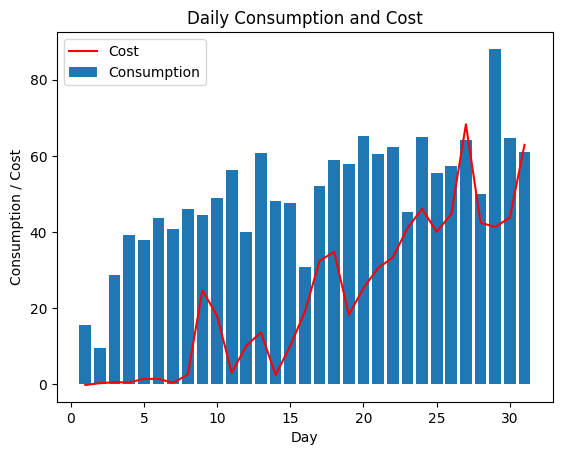

In [75]:
import matplotlib.pyplot as plt

# Extract the day and consumption values from the day_data list
days = [day["Day"] for day in day_data]
consumption = [day["KWH"] for day in day_data]
cost = [day["Cost"] for day in day_data]

# Plot the bar chart for consumption
plt.bar(days, consumption, label='Consumption')

# Plot the line chart for cost
plt.plot(days, cost, color='r', label='Cost')

plt.xlabel("Day")
plt.ylabel("Consumption / Cost")
plt.title("Daily Consumption and Cost")
plt.legend()
plt.show()


In [76]:
# Get the average price for the given day of month including VAT
day_number = 19
price_01 = 0
hours_01 = 0

for price in month_prices[str(day_number)]:
    hours_01 += 1
    price_01 += price["NOK_per_kWh"]
print(f'Gjennomsnitt per dag ex mva: {(price_01 / hours_01)}')  
print(f'Gjennomsnitt per dag ink mva: {(price_01 / hours_01)*1.25}')    

Gjennomsnitt per dag ex mva: 0.31621250000000006
Gjennomsnitt per dag ink mva: 0.39526562500000006


In [77]:
# Calculate the average price and cost for the month using the average spotprice 

day_average = []
hours_month = 0
cost = 0
for i, day in enumerate(dager):
    for hour in day["Hours"]:
        hours_month += 1
        cost += hour["SpotPrice"]
    day_average.append({"Day": day["Day"], "KWH": kwh, "Cost": cost})

daily_average = cost / hours_month*100
daily_average_incl_mva = daily_average * 1.25

print(day_average[0])
print(hours_month)
print("Ved gjennomsnittlig spotpris:")
print(f"Gjennomsnittlig pris per kwh: {daily_average:.2f}")
print(f"Gjennomsnittlig pris per kwh ink mva i øre: {daily_average_incl_mva:.4f}")
print(f'Totale kostnader ved gjennomsnittspris: {daily_average*total_kwh/100:.2f}')
print(f'Totale kostnader ved gjennomsnittspris ink mva: {daily_average_incl_mva*total_kwh/100:.2f}')
# print(cost/hours_month)



{'Day': 1, 'KWH': 60.93999999999998, 'Cost': -0.18748000000000004}
744
Ved gjennomsnittlig spotpris:
Gjennomsnittlig pris per kwh: 43.04
Gjennomsnittlig pris per kwh ink mva i øre: 53.8007
Totale kostnader ved gjennomsnittspris: 665.34
Totale kostnader ved gjennomsnittspris ink mva: 831.68


In [80]:
import calendar

print(f"Måned: {calendar.month_name[period]}")
print(f"Totalt antall dager i måneden: {num_days}")
print(f"Totalt antall kwh: {total_kwh:.2f}\n")

print("\033[1m" + "Mitt faktiske forbruk:" + "\033[0m")
print(f"Totalt antall kroner: {total_cost:.2f}")
print(f"Totalt antall kroner inkl mva: {total_cost_incl_mva:.2f}\n")

print(f"Gjennomsnittlig pris per kwh forbrukt i øre: {average_cost*100:.2f}")
print(f"Gjennomsnittlig pris per kwh ink mva i øre: {average_cost*1.25*100:.2f}")
print(f"Gjennomsnittlig pris for måneden per dag: {average_price:.2f}\n")

print("\033[1m" + "Ved gjennomsnittlig spotpris:" + "\033[0m")
print(f'Totale kostnader ved gjennomsnittspris: {daily_average*total_kwh/100:.2f}')
print(f'Totale kostnader ved gjennomsnittspris ink mva: {daily_average_incl_mva*total_kwh/100:.2f}\n')
print(f"Gjennomsnittlig pris per kwh: {daily_average:.2f}")
print(f"Gjennomsnittlig pris per kwh ink mva i øre: {daily_average_incl_mva:.4f}\n")




Måned: October
Totalt antall dager i måneden: 31
Totalt antall kwh: 1545.85

Mitt faktiske forbruk:
Totalt antall kroner: 713.19
Totalt antall kroner inkl mva: 891.49

Gjennomsnittlig pris per kwh forbrukt i øre: 46.14
Gjennomsnittlig pris per kwh ink mva i øre: 57.67
Gjennomsnittlig pris for måneden per dag: 23.01

Ved gjennomsnittlig spotpris:
Totale kostnader ved gjennomsnittspris: 665.34
Totale kostnader ved gjennomsnittspris ink mva: 831.68

Gjennomsnittlig pris per kwh: 43.04
Gjennomsnittlig pris per kwh ink mva i øre: 53.8007

Delta mellom fakturert og faktisk ved spot:
Totalt antall kroner uten mva: -99.77
Totalt antall kroner inkl mva: -124.72



In [83]:
print("\033[1m" + "Faktisk kostnad for forbruk ved spot:" + "\033[0m")
print(f"Totalt antall kroner: {total_cost:.2f}")
print(f"Totalt antall kroner inkl mva: {total_cost_incl_mva:.2f}\n")

print("\033[1m" + "Fakturert fra Fortum:" + "\033[0m")
print(f"Totalt antall kroner uten mva: {(price_from_fortum_per_kwh*total_kwh):.2f}")
print(f"Totalt antall kroner inkl mva: {(price_from_fortum_per_kwh*total_kwh*1.25):.2f}\n")

print("\033[1m" + "Delta mellom fakturert og faktisk ved spot:" + "\033[0m")
print(f"Totalt antall kroner uten mva: {(total_cost-price_from_fortum_per_kwh*total_kwh):.2f}")
print(f"Totalt antall kroner inkl mva: {(total_cost_incl_mva-price_from_fortum_per_kwh*total_kwh*1.25):.2f}\n")

Faktisk kostnad for forbruk ved spot:
Totalt antall kroner: 713.19
Totalt antall kroner inkl mva: 891.49

Fakturert fra Fortum:
Totalt antall kroner uten mva: 812.96
Totalt antall kroner inkl mva: 1016.20

Delta mellom fakturert og faktisk ved spot:
Totalt antall kroner uten mva: -99.77
Totalt antall kroner inkl mva: -124.72

